## MLOps Pipeline: Big Data, Images, Convolutional Neural Network

The aim of the project is to correctly identify the weed type from a variety of weed and crop RGB images. The project follows MLOps best practices to deploy the model to production.

### What is the objective of the ML model?

Maximize accuracy, which is the correct classification of the different weed varieties.

### Dataset source:
https://www.kaggle.com/vbookshelf/v2-plant-seedlings-dataset

====================================================================================================

# 1. Project Setup

In [33]:
# Standard Packages
import pandas as pd
pd.pandas.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Folder Navigation
from glob import glob
from pathlib import Path
import os

# Image Manipulation
import cv2

# Data Pre-processing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
# model evaluation 
from sklearn.metrics import confusion_matrix

# TensorFlow CNN
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Activation
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.preprocessing import image
from keras.utils import np_utils

## 1.1 Load Images

In [2]:
# iterate folders for each weed class and then iterate over images per weed class
def iter_dir() -> pd.DataFrame:
    DATA_PATH = Path.cwd().resolve().parent / 'data/plant_seedlings_v2'
    VALID_EXTENSIONS = {'.png', '.jpg'}
    images_df = [] # list with dataframes (path, target)
    for class_folder_path in Path.iterdir(DATA_PATH): # iter subdirectories
        if class_folder_path.is_dir(): # check if directory
            for image in Path.iterdir(class_folder_path): # iter files
                if image.is_file(): # check if file
                    if image.suffix in VALID_EXTENSIONS: # check if image
                        tmp = pd.DataFrame([str(image), str(class_folder_path.name)]).T
                        tmp.columns = ['image', 'target']
                        images_df.append(tmp)
    
    # concatenate the final df
    images_df = pd.concat(images_df, axis=0, ignore_index=True)
    return images_df

In [3]:
images_df = iter_dir()

In [4]:
images_df.head()

,image,target
0,/home/daniel/Documents/mlops_dnn_plant_seedlin...,Maize
1,/home/daniel/Documents/mlops_dnn_plant_seedlin...,Maize
2,/home/daniel/Documents/mlops_dnn_plant_seedlin...,Maize
3,/home/daniel/Documents/mlops_dnn_plant_seedlin...,Maize
4,/home/daniel/Documents/mlops_dnn_plant_seedlin...,Maize


In [6]:
# how many images do we've got per class?
images_df['target'].value_counts()

Loose Silky-bent             762
Common Chickweed             713
Scentless Mayweed            607
Small-flowered Cranesbill    576
Fat Hen                      538
Sugar beet                   463
Charlock                     452
Cleavers                     335
Black-grass                  309
Shepherds Purse              274
Maize                        257
Common wheat                 253
Name: target, dtype: int64

## 1.2. Visualize images

In [7]:
# image path for first image
images_df.loc[0, 'image']

'/home/daniel/Documents/mlops_dnn_plant_seedlings/data/plant_seedlings_v2/Maize/155.png'

In [8]:
def plot_for_class(df, label):
    # function plots 9 images
    nb_rows = 3
    nb_cols = 3
    
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(10, 10))

    n = 0
    for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            tmp = df[df['target'] == label ]
            tmp.reset_index(drop=True, inplace=True)
            im = cv2.imread(tmp.loc[n, 'image'])          
            axs[i, j].imshow(im)
            n += 1 

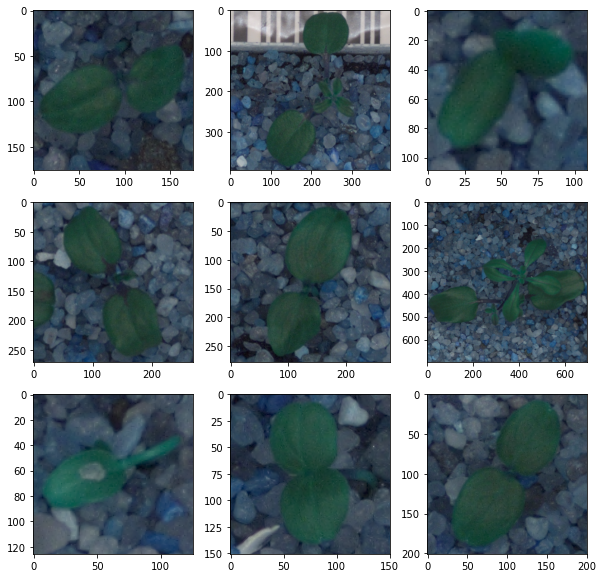

In [9]:
plot_for_class(images_df, 'Cleavers')

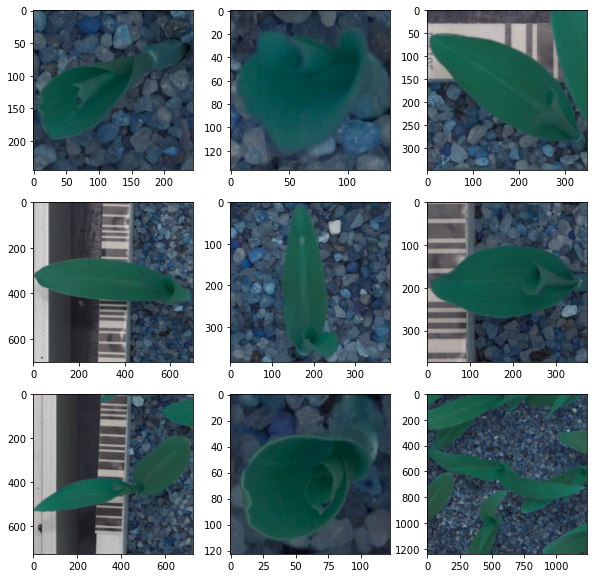

In [10]:
plot_for_class(images_df, 'Maize')

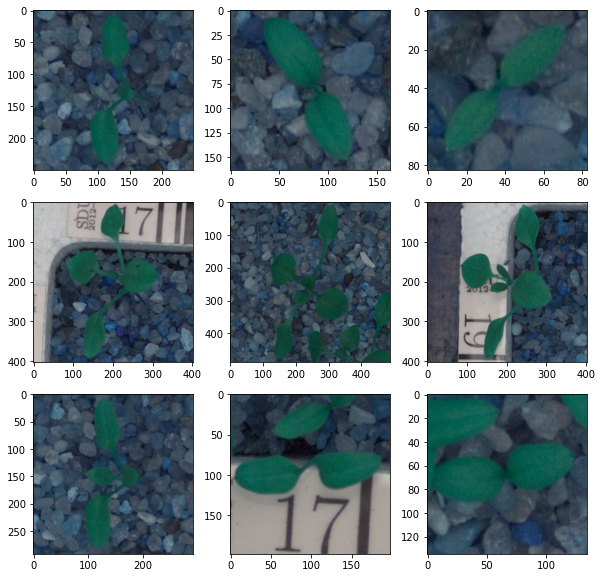

In [11]:
plot_for_class(images_df, 'Common Chickweed')

# 2. Train / Test Split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(images_df['image'], images_df['target'], test_size=0.20, random_state=101)

print(X_train.shape)
print(X_test.shape)

(4431,)
(1108,)


In [13]:
X_train.head()

1922    /home/daniel/Documents/mlops_dnn_plant_seedlin...
4164    /home/daniel/Documents/mlops_dnn_plant_seedlin...
2952    /home/daniel/Documents/mlops_dnn_plant_seedlin...
287     /home/daniel/Documents/mlops_dnn_plant_seedlin...
4971    /home/daniel/Documents/mlops_dnn_plant_seedlin...
Name: image, dtype: object

In [14]:
# reset index, because later we iterate over row number
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)

X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

X_train.head()

0    /home/daniel/Documents/mlops_dnn_plant_seedlin...
1    /home/daniel/Documents/mlops_dnn_plant_seedlin...
2    /home/daniel/Documents/mlops_dnn_plant_seedlin...
3    /home/daniel/Documents/mlops_dnn_plant_seedlin...
4    /home/daniel/Documents/mlops_dnn_plant_seedlin...
Name: image, dtype: object

In [15]:
# percentage of images within each class
y_train.value_counts() / len(y_train)

Loose Silky-bent             0.135635
Common Chickweed             0.129542
Scentless Mayweed            0.110133
Small-flowered Cranesbill    0.102460
Fat Hen                      0.099752
Sugar beet                   0.081923
Charlock                     0.081697
Cleavers                     0.062965
Black-grass                  0.055969
Shepherds Purse              0.049199
Maize                        0.045588
Common wheat                 0.045137
Name: target, dtype: float64

In [16]:
# should be the same in the test set
y_test.value_counts() / len(y_test)

Loose Silky-bent             0.145307
Common Chickweed             0.125451
Small-flowered Cranesbill    0.110108
Scentless Mayweed            0.107401
Sugar beet                   0.090253
Fat Hen                      0.086643
Charlock                     0.081227
Black-grass                  0.055054
Shepherds Purse              0.050542
Cleavers                     0.050542
Maize                        0.049639
Common wheat                 0.047834
Name: target, dtype: float64

# 3. Data Transformation

In [17]:
# it is a multiclass classification, so we need to make one hot encoding of the target

encoder = LabelEncoder()
encoder.fit(y_train)

train_y = np_utils.to_categorical(encoder.transform(y_train))
test_y = np_utils.to_categorical(encoder.transform(y_test))

train_y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [57]:
# The images in our folders, are all different sizes, lets resize them
IMAGE_SIZE = 32

In [58]:
def image_resize(df, n):
    image = cv2.imread(df[n])
    image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
    return image

In [59]:
# try resizing image #7
tmp = image_resize(X_train, 7)
tmp.shape

(32, 32, 3)

In [60]:
# the shape of the datasets needs to be (number of observations, width, length, rgb)

def create_dataset(df, image_size):
    # functions creates dataset as required for cnn
    number_observations = len(df)
    width, length = image_size, image_size
    rgb = 3
    
    tmp = np.zeros((number_observations, width, length, rgb), dtype='float32')

    for n in range(0, len(df)):
        image = image_resize(df, n)
        tmp[n] = image
  
    print('Dataset Images shape: {} size: {:,}'.format(tmp.shape, tmp.size))
    return tmp

In [61]:
x_train = create_dataset(X_train, IMAGE_SIZE)

Dataset Images shape: (4431, 32, 32, 3) size: 13,612,032


In [62]:
x_test = create_dataset(X_test, IMAGE_SIZE)

Dataset Images shape: (1108, 32, 32, 3) size: 3,403,776


In [63]:
# number of different classes
len(y_train.unique())

12

# 4. Model definition
https://www.kaggle.com/fmarazzi/baseline-keras-cnn-roc-fast-5min-0-8253-lb

In [64]:
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.3

model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(MaxPooling2D(pool_size = pool_size, padding='same')) 
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size, padding='same'))
model.add(Dropout(dropout_conv))

model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size, padding='same'))
model.add(Dropout(dropout_conv))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(12, activation = "softmax"))

model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_42 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 conv2d_43 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 14, 14, 32)       0         
 g2D)                                                            
                                                                 
 dropout_18 (Dropout)        (None, 14, 14, 32)        0         
                                                                 
 conv2d_44 (Conv2D)          (None, 12, 12, 64)        18496     
                                                                 
 conv2d_45 (Conv2D)          (None, 10, 10, 64)        36928     
                                                      

In [65]:
model.compile(Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# 5. Model training

In [82]:
batch_size = 10
epochs = 20

In [83]:
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=2, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(monitor='accuracy', factor=0.5, patience=1, verbose=1, mode='max', min_lr=0.00001)
                                                           
callbacks_list = [reduce_lr, checkpoint]

history = model.fit(x=x_train, y=train_y,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=2,
                    callbacks=callbacks_list)

Epoch 1/20

Epoch 1: accuracy improved from -inf to 0.73685, saving model to model.h5
444/444 - 4s - loss: 0.1127 - accuracy: 0.7369 - lr: 1.0000e-04 - 4s/epoch - 9ms/step
Epoch 2/20

Epoch 2: accuracy improved from 0.73685 to 0.74430, saving model to model.h5
444/444 - 4s - loss: 0.1094 - accuracy: 0.7443 - lr: 1.0000e-04 - 4s/epoch - 9ms/step
Epoch 3/20

Epoch 3: accuracy improved from 0.74430 to 0.75694, saving model to model.h5
444/444 - 4s - loss: 0.1044 - accuracy: 0.7569 - lr: 1.0000e-04 - 4s/epoch - 8ms/step
Epoch 4/20

Epoch 4: accuracy improved from 0.75694 to 0.77183, saving model to model.h5
444/444 - 4s - loss: 0.0990 - accuracy: 0.7718 - lr: 1.0000e-04 - 4s/epoch - 8ms/step
Epoch 5/20

Epoch 5: accuracy improved from 0.77183 to 0.77477, saving model to model.h5
444/444 - 4s - loss: 0.0978 - accuracy: 0.7748 - lr: 1.0000e-04 - 4s/epoch - 8ms/step
Epoch 6/20

Epoch 6: accuracy improved from 0.77477 to 0.78560, saving model to model.h5
444/444 - 4s - loss: 0.0924 - accuracy:

# 6. Model evaluation

<Figure size 432x288 with 0 Axes>

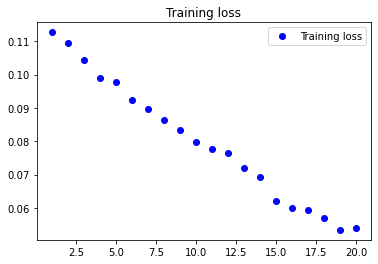

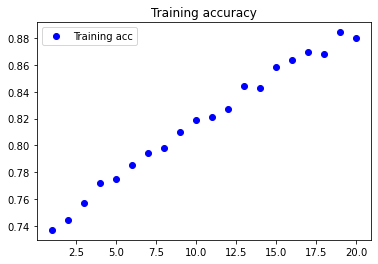

<Figure size 432x288 with 0 Axes>

In [85]:
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.title('Training loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.title('Training accuracy')
plt.legend()
plt.figure()

# 7. Prediction

In [87]:
# make a prediction
predictions = model.predict(x_test, verbose=1)

35/35 [==============================] - 0s 4ms/step


In [88]:
# inspect predictions
predictions

array([[8.9519989e-12, 4.4057713e-12, 7.4837754e-11, ..., 2.9823182e-11,
        9.9999994e-01, 3.7853748e-10],
       [6.2316150e-15, 8.7310562e-13, 7.0710217e-15, ..., 8.9589731e-11,
        2.2335668e-12, 5.2257569e-13],
       [1.8363464e-05, 3.4493728e-06, 2.7616874e-05, ..., 3.5540722e-04,
        8.7268927e-06, 4.1011707e-03],
       ...,
       [5.3938997e-22, 1.0000000e+00, 9.8312658e-16, ..., 8.4481047e-14,
        4.0285781e-15, 1.8973017e-18],
       [1.7398287e-16, 1.1473801e-16, 9.0577807e-16, ..., 4.0197096e-13,
        3.3706322e-13, 4.2022650e-14],
       [3.3948959e-03, 3.1049415e-03, 3.5347550e-03, ..., 1.0432428e-02,
        7.3435885e-01, 7.1565911e-02]], dtype=float32)

In [89]:
# transform target
encoder.transform(y_test)

array([10,  7,  8, ...,  1,  3,  3])

In [93]:
encoder.transform(y_test), predictions

(array([10,  7,  8, ...,  1,  3,  3]),
 array([[8.9519989e-12, 4.4057713e-12, 7.4837754e-11, ..., 2.9823182e-11,
         9.9999994e-01, 3.7853748e-10],
        [6.2316150e-15, 8.7310562e-13, 7.0710217e-15, ..., 8.9589731e-11,
         2.2335668e-12, 5.2257569e-13],
        [1.8363464e-05, 3.4493728e-06, 2.7616874e-05, ..., 3.5540722e-04,
         8.7268927e-06, 4.1011707e-03],
        ...,
        [5.3938997e-22, 1.0000000e+00, 9.8312658e-16, ..., 8.4481047e-14,
         4.0285781e-15, 1.8973017e-18],
        [1.7398287e-16, 1.1473801e-16, 9.0577807e-16, ..., 4.0197096e-13,
         3.3706322e-13, 4.2022650e-14],
        [3.3948959e-03, 3.1049415e-03, 3.5347550e-03, ..., 1.0432428e-02,
         7.3435885e-01, 7.1565911e-02]], dtype=float32))

In [94]:
cnf_matrix = confusion_matrix(encoder.transform(y_test), np.argmax(predictions, axis=1))

In [96]:
# create a dict to map back the numbers onto the classes
tmp = pd.concat([y_test, pd.Series(encoder.transform(y_test))], axis=1)
tmp.columns = ['class_name', 'class_number']
tmp.drop_duplicates(inplace=True)
tmp.reset_index(drop=True, inplace=True)
tmp = pd.Series(tmp.class_name.values,index=tmp.class_number).to_dict()
tmp

{10: 'Small-flowered Cranesbill',
 7: 'Maize',
 8: 'Scentless Mayweed',
 6: 'Loose Silky-bent',
 1: 'Charlock',
 5: 'Fat Hen',
 9: 'Shepherds Purse',
 3: 'Common Chickweed',
 0: 'Black-grass',
 2: 'Cleavers',
 11: 'Sugar beet',
 4: 'Common wheat'}

In [97]:
# these we will display in the below matrix
abbreviation = ['BG', 'Ch', 'Cl', 'CC', 'CW', 'FH', 'LSB', 'M', 'SM', 'SP', 'SFC', 'SB']

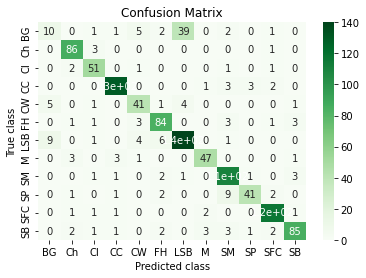

In [107]:
import seaborn as sns

fig, ax = plt.subplots(1)
ax = sns.heatmap(cnf_matrix, ax=ax, cmap=plt.cm.Greens, annot=True)
ax.set_xticklabels(abbreviation)
ax.set_yticklabels(abbreviation)
plt.title('Confusion Matrix')
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show();

In [108]:
from sklearn.metrics import  accuracy_score
accuracy_score(encoder.transform(y_test), np.argmax(predictions, axis=1), normalize=True, sample_weight=None)

0.8492779783393501

In [109]:
from sklearn.metrics import  classification_report
print(classification_report(encoder.transform(y_test), np.argmax(predictions, axis=1)))

              precision    recall  f1-score   support

           0       0.42      0.16      0.24        61
           1       0.90      0.96      0.92        90
           2       0.84      0.91      0.87        56
           3       0.94      0.94      0.94       139
           4       0.75      0.77      0.76        53
           5       0.85      0.88      0.86        96
           6       0.76      0.87      0.81       161
           7       0.89      0.85      0.87        55
           8       0.83      0.92      0.88       119
           9       0.89      0.73      0.80        56
          10       0.92      0.95      0.94       122
          11       0.90      0.85      0.88       100

    accuracy                           0.85      1108
   macro avg       0.82      0.82      0.81      1108
weighted avg       0.84      0.85      0.84      1108

